In [1]:
!git clone https://github.com/CausalML/BLearner.git

fatal: destination path 'BLearner' already exists and is not an empty directory.


In [2]:
cd BLearner

/home/takeshima/Projects/CausalInference/BLearner/BLearner


In [3]:
from sklearn_quantile import RandomForestQuantileRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from models.blearner.nuisance import RFKernel, KernelSuperquantileRegressor
from models.blearner import BLearner
import lightgbm
from sklearn import clone

from datasets import synthetic

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
#データ生成器
generator = synthetic.Synthetic(num_examples=10000, gamma_star=1, mode='mu')

In [5]:
raw = pd.DataFrame()
raw["x"] = generator.x[:,0]
raw["y"] = generator.y
raw["t"] = generator.t
raw["f"] = generator.tau_fn(generator.x)

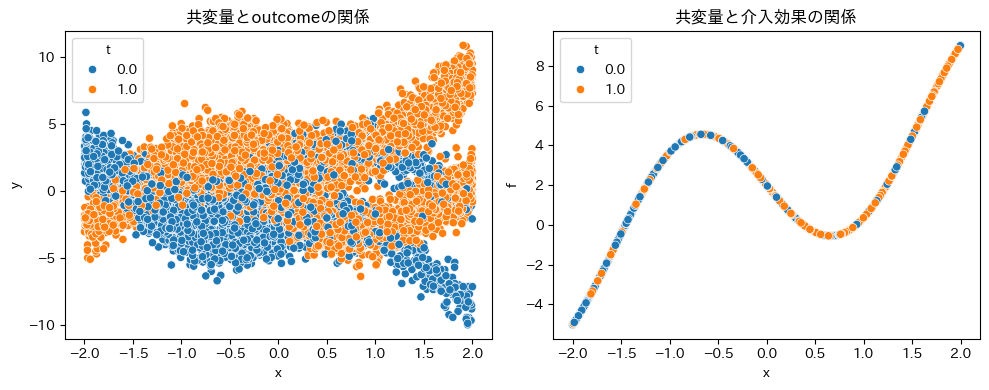

In [6]:
fig, axes = plt.subplots(figsize=(10, 4), ncols=2, tight_layout=True)
sns.scatterplot(raw, x="x", y="y", hue="t", ax=axes[0])
sns.scatterplot(raw, x="x", y="f", hue="t", ax=axes[1])
axes[0].set(title="共変量とoutcomeの関係")
axes[1].set(title="共変量と介入効果の関係")
plt.show()

In [7]:
print(f'ATE:{raw["f"].mean()}')

ATE:2.021308422088623


In [8]:
gamma = np.e
tau = gamma / (1+gamma)

In [9]:
#傾向スコアモデル
propensity_model = lightgbm.LGBMClassifier()

#outcomeモデル
mu_model = lightgbm.LGBMRegressor()

#四分位予測モデル
quantile_model_upper = RandomForestQuantileRegressor(q=tau)
quantile_model_lower = RandomForestQuantileRegressor(q=1-tau)

#CVaR上界モデル
cvar_model_upper = KernelSuperquantileRegressor(kernel=RFKernel(clone(mu_model, safe=False)),
                                                tau=tau, tail="right")
#CVaR下界モデル
cvar_model_lower = KernelSuperquantileRegressor(kernel=RFKernel(clone(mu_model, safe=False)),
                                                tau=1-tau, tail="left")

# CATE境界モデル
cate_bounds_model = lightgbm.LGBMRegressor()

In [10]:
# BLearner estimator
estimator = BLearner(propensity_model = propensity_model,
                     mu_model = mu_model,
                     quantile_plus_model  = quantile_model_upper,
                     quantile_minus_model = quantile_model_lower,
                     cvar_plus_model   = cvar_model_upper,
                     cvar_minus_model  = cvar_model_lower,
                     cate_bounds_model = cate_bounds_model,
                     use_rho=True,
                     gamma=gamma)

In [11]:
feat_names = ['x']
X = raw[feat_names].values
A = raw["t"].values
Y = raw["y"].values

In [12]:
estimator.fit(X, A, Y)

[LightGBM] [Info] Number of positive: 4827, number of negative: 3173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.603375 -> initscore=0.419548
[LightGBM] [Info] Start training from score 0.419548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 3173, number of used features: 1
[LightGBM] [Info] Start training from score -0.646826
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] 

In [13]:
effects = estimator.effect(X)

raw["lower"] = effects[0]
raw["upper"] = effects[1]
raw["mean"] = estimator.mu1(X) - estimator.mu0(X)

In [14]:
print(f'estimated ATE:{raw["mean"].mean()}')

estimated ATE:2.0081604922300373


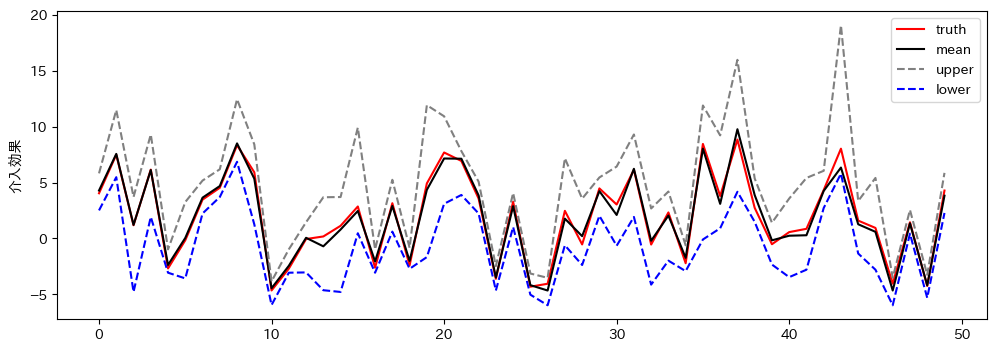

In [15]:
period = 50
plots = raw.sample(period).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(12,4))
sns.lineplot(plots, x=plots.index, y="f", label="truth", color="red")
sns.lineplot(plots, x=plots.index, y="mean", label="mean", color="black")
sns.lineplot(plots, x=plots.index, y="upper", label="upper", color="grey", ls="--")
sns.lineplot(plots, x=plots.index, y="lower", label="lower", color="blue", ls="--")
ax.set(xlabel="", ylabel="介入効果")
plt.show()

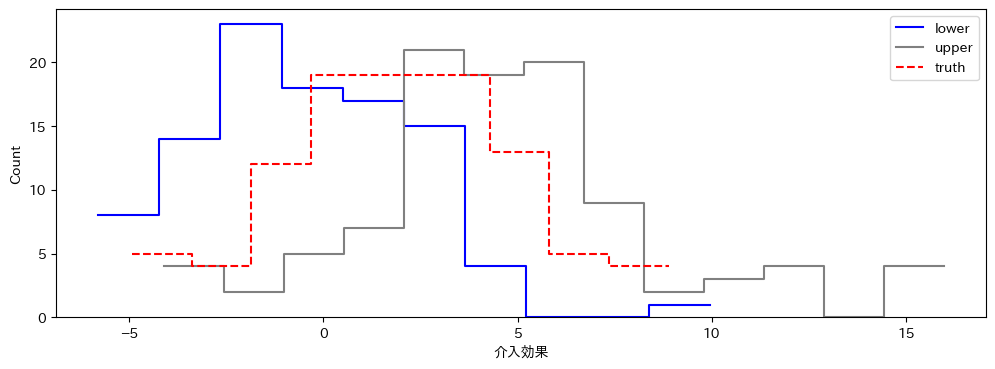

In [16]:
period = 100
plots = raw.sample(period)

fig, ax = plt.subplots(figsize=(12,4))
sns.histplot(plots, x="lower",fill=False, element="step", color="blue", label="lower", ls="-")
sns.histplot(plots, x="upper",fill=False, element="step", color="grey", label="upper", ls="-")
sns.histplot(plots, x="f", fill=False, element="step", color="red", label="truth", ls="--")
ax.set(xlabel="介入効果")
ax.legend()
plt.show()